<a href="https://colab.research.google.com/github/Muhammadridho100902/google_collab/blob/main/weekly_CO2_concentration_from_1958_to_2001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

In [ ]:
data = sm.datasets.co2.load_pandas().data

In [ ]:
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


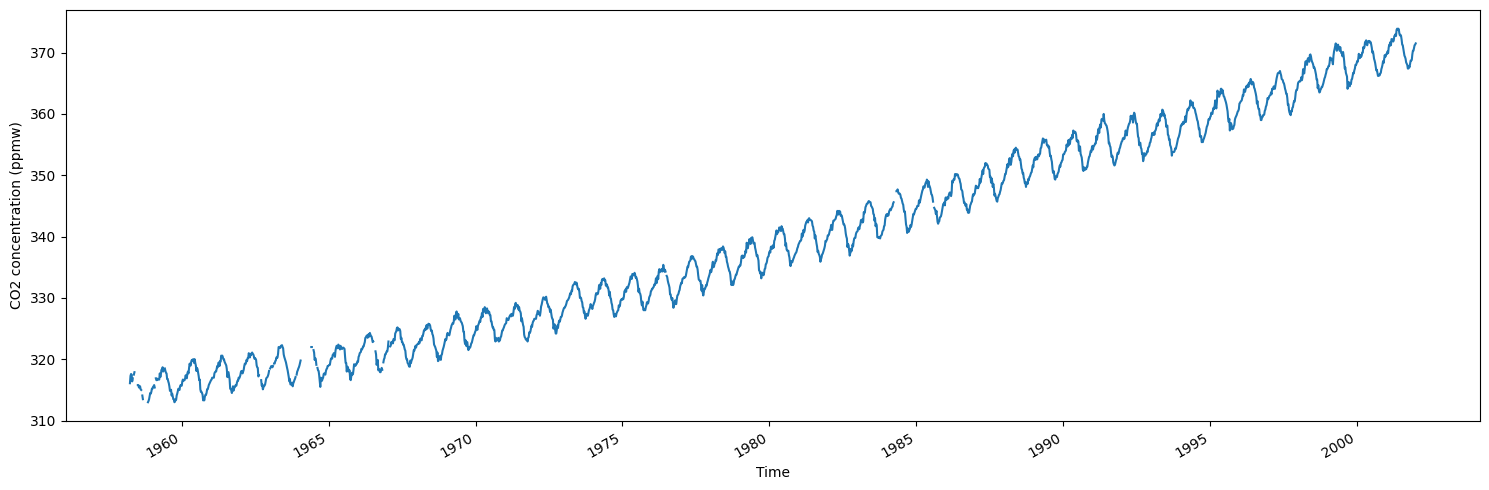

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))

ax.plot(data['co2'])
ax.set_xlabel('Time')
ax.set_ylabel('CO2 concentration (ppmw)')

fig.autofmt_xdate()
plt.tight_layout()

From the image above, we notice clear positive trends as the consentration increasing over the time 

# Handel Missing Values

In [ ]:
data = data.interpolate()

# Modelling with scikit-learn

#There are 3 different ways in which we can frame a time series forecasting problem as a supervised learning problem:

1. Predict the next time step using the previous observation
2. Predict the next time step using a sequence of past observations
3. Predict a sequence of future time steps using a sequence of past observations

# Let’s explore each situation in details!

1. Predict the next time step using the previous observation

This is a simple use case with little practical applications, since a model is likely not going to learn anything from the previous observation only. However, it serves as a good starting point to help us understand the more complex scenarios later on.

In [ ]:
data.head()

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [ ]:
df = data.copy()
df['y'] = df['co2'].shift(-1)

In [ ]:
df.head()

,co2,y
1958-03-29,316.1,317.3
1958-04-05,317.3,317.6
1958-04-12,317.6,317.5
1958-04-19,317.5,316.4
1958-04-26,316.4,316.9


seperate the dataset into training and test set

In [ ]:
train = df[:-104]
test = df[-104:]
test = test.drop(test.tail(1).index) # drop last row

Try "Baseline Model"

we use co2 column as our baseline prediction

In [ ]:
test = test.copy()
test['baseline_pred'] = test['co2']

In [ ]:
test.head()

,co2,y,baseline_pred
2000-01-08,368.5,369.0,368.5
2000-01-15,369.0,369.8,369.0
2000-01-22,369.8,369.2,369.8
2000-01-29,369.2,369.1,369.2
2000-02-05,369.1,369.6,369.1


# Decision Trees

This model can be replaced by any model you want from the scikit-learn library! Note that we use a random state to ensure reproducibility.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

x_train = train['co2'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
x_test = test['co2'].values.reshape(-1,1)

# initialize the models
dt_reg = DecisionTreeRegressor(random_state=42)

# fit the model
dt_reg.fit(x_train,y_train)

# make prediction
dt_pred = dt_reg.predict(x_test)

# assign the prediction to new columns
test['dt_pred'] = dt_pred


In [ ]:
test.head()

,co2,y,baseline_pred,dt_pred
2000-01-08,368.5,369.0,368.5,368.65
2000-01-15,369.0,369.8,369.0,368.50
2000-01-22,369.8,369.2,369.8,369.40
2000-01-29,369.2,369.1,369.2,369.10
2000-02-05,369.1,369.6,369.1,368.80


# Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(x_train, y_train.ravel())
gbr_pred = gbr.predict(x_test)
test['gbr_pred'] = gbr_pred

In [ ]:
test.head()

,co2,y,baseline_pred,dt_pred,gbr_pred
2000-01-08,368.5,369.0,368.5,368.65,368.556464
2000-01-15,369.0,369.8,369.0,368.50,368.774435
2000-01-22,369.8,369.2,369.8,369.40,369.512468
2000-01-29,369.2,369.1,369.2,369.10,369.041813
2000-02-05,369.1,369.6,369.1,368.80,368.774435


# Evaluation Models

we use mean absolute precentage error (MAPE) it return a percentage so it easy to interpret. **Make Sure to only use this if you dont have values close to zero like this case** 

In [ ]:
def mape(y_true, y_pred):
  return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

Than we can evaluate for each model with bar plot

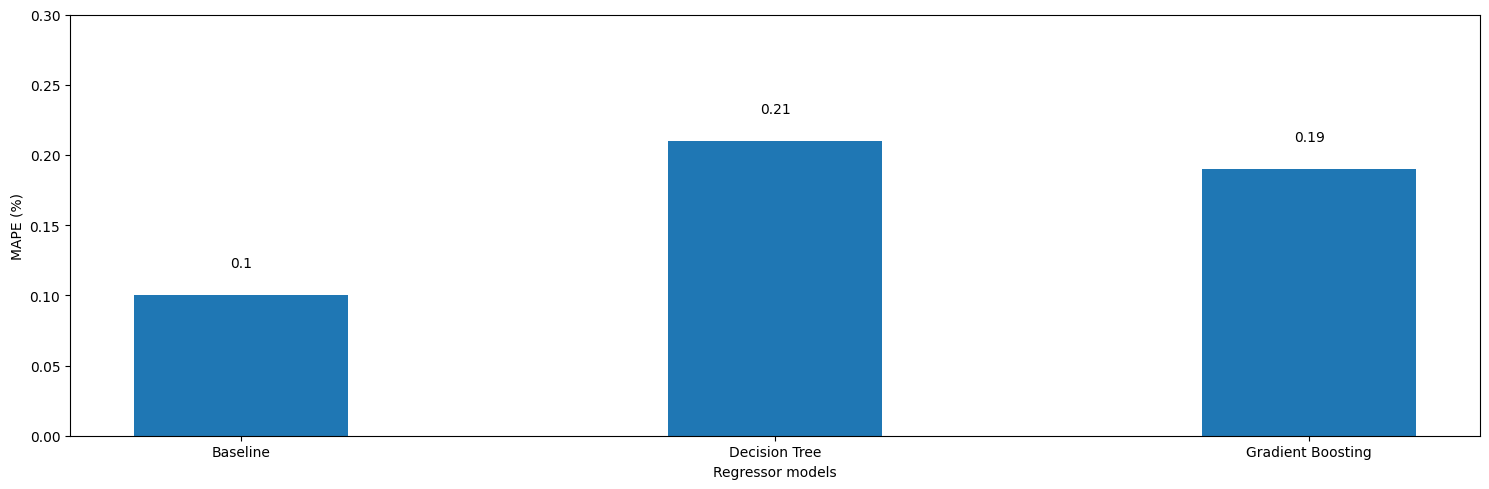

In [ ]:
baseline_mape = mape(test['y'], test['baseline_pred'])
dt_mape = mape(test['y'], test['dt_pred'])
gbr_mape = mape(test['y'], test['gbr_pred'])

# Generate bar plot
fig , ax  = plt.subplots(figsize=(15,5))

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_mape, gbr_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 0.3)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.02, s=str(value), ha='center')
    
plt.tight_layout()



**Looking at the figure above, we see that the baseline has the best performance, since it has the lowest MAPE. This makes sense as the CO2 concentration does not seem to change drastically from one week to another.**

**In this case, using machine learning models did not give us any added value. Again, this might be because the model is only learning from one observation to make a prediction. It might be better to give it a sequence as input, in order to predict the next time step.**

# Predict the next time step using a sequence of past observations

In [ ]:
def window_input(window_length: int, data: pd.DataFrame) -> pd.DataFrame:
  df = data.copy()

  i = 1
  while i < window_length:
    df[f'x_{i}'] = df['co2'].shift(-i)
    i = i + 1

  if i == window_length:
    df['y'] = df['co2'].shift(-i)

  # drop rows where thers have NaN
  df = df.dropna(axis=0)

  return df

In [ ]:
new_df = window_input(5, data)

In [ ]:
new_df

,co2,x_1,x_2,x_3,x_4,y
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55
...,...,...,...,...,...,...
2001-10-27,368.7,368.7,368.8,369.7,370.3,370.30
2001-11-03,368.7,368.8,369.7,370.3,370.3,370.80
2001-11-10,368.8,369.7,370.3,370.3,370.8,371.20
2001-11-17,369.7,370.3,370.3,370.8,371.2,371.30


Split the data above into train and test set

In [ ]:
from sklearn.model_selection import train_test_split

x = new_df[['co2', 'x_1', 'x_2', 'x_3', 'x_4']].values
y = new_df['y'].values

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.3, random_state=42, shuffle=False)

# Baseline Model

In [ ]:
baseline_pred = []

for row in x_test:
  baseline_pred.append(np.mean(row))

# Decision Tree

In [ ]:
dt_reg_5 = DecisionTreeRegressor(random_state=42)

dt_reg_5.fit(x_train, y_train)

dt_reg_5_pred = dt_reg_5.predict(x_test)

# Gradient Boosting

In [ ]:
gbr_5 = GradientBoostingRegressor(random_state=42)
gbr_5.fit(x_train, y_train.ravel())
gbr_5_pred = gbr_5.predict(x_test)

# Evaluation Using MAPE

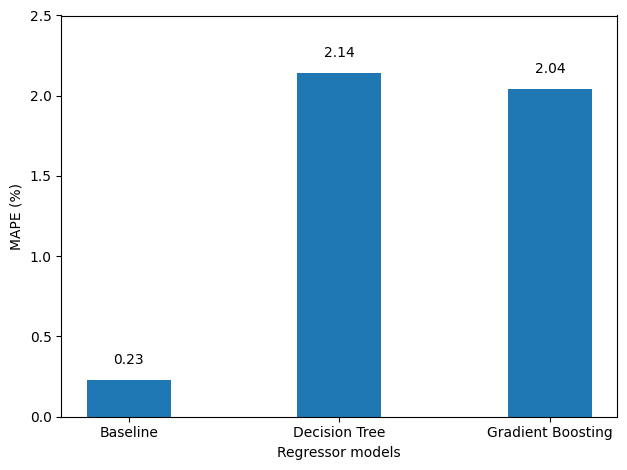

In [ ]:
baseline_mape = mape(y_test, baseline_pred)
dt_5_mape = mape(y_test, dt_reg_5_pred)
gbr_5_mape = mape(y_test, gbr_5_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [baseline_mape, dt_5_mape, gbr_5_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

# 3. Predict a sequence of future time steps using a sequence of past observations

In [ ]:
def window_input_output(input_length: int, output_length: int, data: pd.DataFrame) -> pd.DataFrame:
    
    df = data.copy()
    
    i = 1
    while i < input_length:
        df[f'x_{i}'] = df['co2'].shift(-i)
        i = i + 1
        
    j = 0
    while j < output_length:
        df[f'y_{j}'] = df['co2'].shift(-output_length-j)
        j = j + 1
        
    df = df.dropna(axis=0)
    
    return df

In [ ]:
seq_df = window_input_output(26, 26, data)
seq_df.head()

,co2,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,...,y_16,y_17,y_18,y_19,y_20,y_21,y_22,y_23,y_24,y_25
1958-03-29,316.1,317.3,317.6,317.5,316.4,316.90,317.20,317.50,317.90,317.55,...,315.60,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.7
1958-04-05,317.3,317.6,317.5,316.4,316.9,317.20,317.50,317.90,317.55,317.20,...,315.80,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.7
1958-04-12,317.6,317.5,316.4,316.9,317.2,317.50,317.90,317.55,317.20,316.85,...,315.40,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.7
1958-04-19,317.5,316.4,316.9,317.2,317.5,317.90,317.55,317.20,316.85,316.50,...,316.15,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.1
1958-04-26,316.4,316.9,317.2,317.5,317.9,317.55,317.20,316.85,316.50,316.15,...,316.90,316.60,316.60,316.80,316.75,316.70,316.70,317.70,317.10,317.6


**Before moving on to modeling, again, we will split the data into a training and a test set. Here, we reserve the last two rows for the test set, as it gives us 52 test samples.**

In [ ]:
X_cols = [col for col in seq_df.columns if col.startswith('x')]

X_cols.insert(0, 'co2')

y_cols = [col for col in seq_df.columns if col.startswith('y')]

In [ ]:
X_train = seq_df[X_cols][:-2].values
y_train = seq_df[y_cols][:-2].values

X_test = seq_df[X_cols][-2:].values
y_test = seq_df[y_cols][-2:].values

**Decision Tree**

In [ ]:
dt_seq = DecisionTreeRegressor(random_state=42)

dt_seq.fit(X_train, y_train)

dt_seq_preds = dt_seq.predict(X_test)

**Gradient Boostin**

In [ ]:
from sklearn.multioutput import RegressorChain

gbr_seq = GradientBoostingRegressor(random_state=42)

chained_gbr = RegressorChain(gbr_seq)

chained_gbr.fit(X_train, y_train)

gbr_seq_preds = chained_gbr.predict(X_test)

# **EVALUATION MODEL AGAIN**

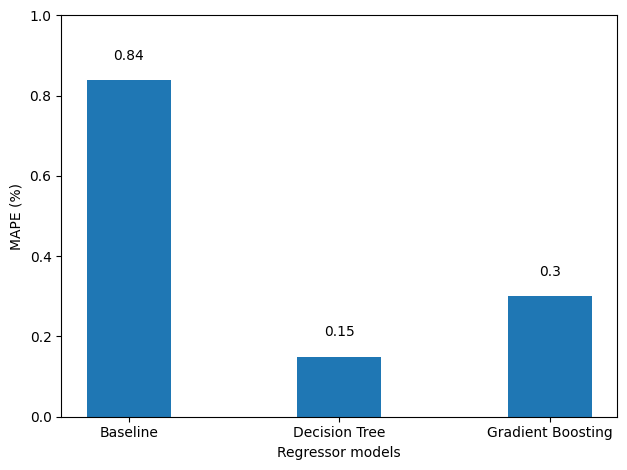

In [ ]:
mape_dt_seq = mape(dt_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_gbr_seq = mape(gbr_seq_preds.reshape(1, -1), y_test.reshape(1, -1))
mape_baseline = mape(X_test.reshape(1, -1), y_test.reshape(1, -1))
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting']
y = [mape_baseline, mape_dt_seq, mape_gbr_seq]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(value), ha='center')
    
plt.tight_layout()

**From the figure above, we can see that we finally managed to train ML models that outperform the baseline! Here, the decision tree model is the champion model, as it achieves the lowest MAPE.**

We optionally visualize the predictions over the last year.**

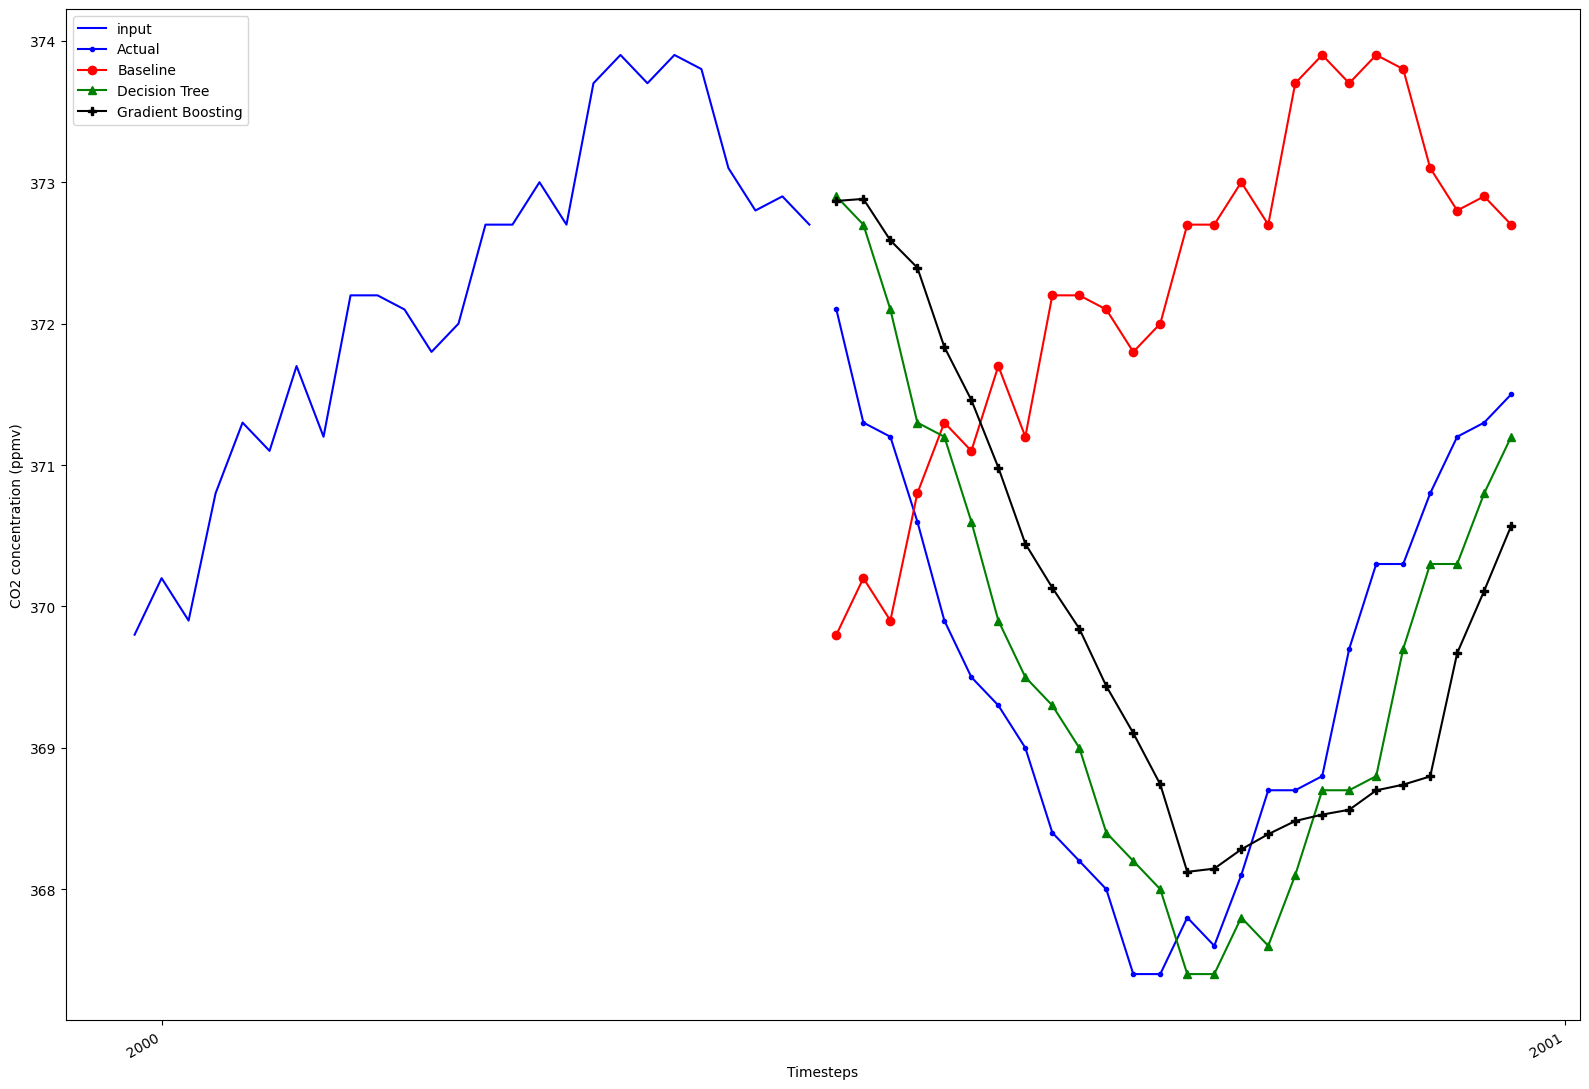

In [ ]:
fig, ax = plt.subplots(figsize=(16, 11))
ax.plot(np.arange(0, 26, 1), X_test[1], 'b-', label='input')
ax.plot(np.arange(26, 52, 1), y_test[1], marker='.', color='blue', label='Actual')
ax.plot(np.arange(26, 52, 1), X_test[1], marker='o', color='red', label='Baseline')
ax.plot(np.arange(26, 52, 1), dt_seq_preds[1], marker='^', color='green', label='Decision Tree')
ax.plot(np.arange(26, 52, 1), gbr_seq_preds[1], marker='P', color='black', label='Gradient Boosting')
ax.set_xlabel('Timesteps')
ax.set_ylabel('CO2 concentration (ppmv)')
plt.xticks(np.arange(1, 104, 52), np.arange(2000, 2002, 1))
plt.legend(loc=2)
fig.autofmt_xdate()
plt.tight_layout()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


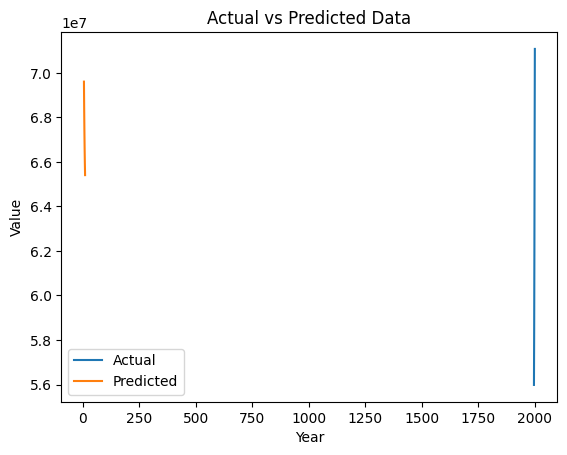

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Create a pandas DataFrame with the provided data
data = pd.DataFrame({
    'Year': [1996, 1997, 1998, 1999, 2000],
    'Total': [50332047.0, 55982040.0, 58504660.0, 62108239.0, 67105675.0],
    'y': [55982040.0, 58504660.0, 62108239.0, 67105675.0, 71072961.0]
})

# Set the 'Year' column as the index
data.set_index('Year', inplace=True)

# Fit the ARIMA model
model = ARIMA(data['y'], order=(1, 0, 0))  # Adjust the order if needed
model_fit = model.fit()

# Generate predictions
predictions = model_fit.predict(start=len(data), end=len(data) + 5)  # Adjust the number of predictions as needed

# Visualize the actual data and predictions
plt.plot(data['y'], label='Actual')
plt.plot(predictions, label='Predicted')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data')
plt.legend()
plt.show()
